In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
import pandas as pd
from pandas.io import gbq
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /Users/vignesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
news_content = """SELECT title  FROM [not-a-doctor-273222.Topic_Modelling.NewsData]"""
news_content = gbq.read_gbq(news_content,project_id="not-a-doctor-273222")

/Users/vignesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  
Downloading: 100%|██████████| 2023/2023 [00:00<00:00, 6258.47rows/s]


In [3]:
news_content['index']=news_content.index
news_content_uniq=news_content.drop_duplicates()

In [38]:
processed_news = news_content_uniq['content'].map(preprocess)
processed_news[:10]

0    [paul, ramchandani, josi, ford, direct, impact...
1    [sever, case, covid, patient, lung, inflam, fl...
2    [larg, consign, test, kit, novel, coronavirus,...
3    [coronavirus, pandem, cut, supermarket, meat, ...
4    [elect, time, know, presid, need, recast, perf...
5    [novel, coronavirus, outbreak, spain, second, ...
6                                                   []
7                                               [rand]
8    [hundr, case, covid, report, postal, servic, t...
9    [graham, lawton, london, health, care, worker,...
Name: content, dtype: object

In [39]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [40]:
doc_sample = news_content_uniq[news_content_uniq['index'] == 2].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['A', 'large', 'consignment', 'of', 'testing', 'kits', 'for', 'the', 'novel', 'coronavirus', 'pandemic', 'is', 'scheduled', 'to', 'reach', 'India', 'from', 'China', 'on', 'Thursday,', 'sources', 'have', 'confirmed.', 'The', 'kits', 'are', 'expected', 'to', 'boost', 'Indias', 'testing', 'capacity', 'in', 'a', 'major', 'way', 'as', 'the', 'country', 'aims', 'to', 'ramp', 'up', 'its', 'testing…', '[+952', 'chars]']


 tokenized and lemmatized document: 
['larg', 'consign', 'test', 'kit', 'novel', 'coronavirus', 'pandem', 'schedul', 'reach', 'india', 'china', 'thursday', 'sourc', 'confirm', 'kit', 'expect', 'boost', 'india', 'test', 'capac', 'major', 'countri', 'aim', 'ramp', 'test', 'char']


In [41]:
dictionary = gensim.corpora.Dictionary(processed_news)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
# dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

0 adult
1 char
2 children
3 choic
4 consequ
5 covid
6 direct
7 effect
8 ford
9 hide
10 impact


In [42]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_news]
# bow_corpus[50]

In [43]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.25577552221497213),
 (1, 0.013753884046657314),
 (2, 0.25577552221497213),
 (3, 0.24960103250878335),
 (4, 0.25260699651925766),
 (5, 0.08993127396345593),
 (6, 0.23891636028017918),
 (7, 0.2239177815980814),
 (8, 0.22583937833879808),
 (9, 0.25577552221497213),
 (10, 0.21046392729708724),
 (11, 0.25577552221497213),
 (12, 0.22583937833879808),
 (13, 0.25260699651925766),
 (14, 0.25260699651925766),
 (15, 0.25577552221497213),
 (16, 0.21198618041447947),
 (17, 0.25577552221497213),
 (18, 0.2168056166885939)]


In [44]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, workers=2)

In [45]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.011*"life" + 0.009*"trump" + 0.009*"pandem" + 0.007*"presid" + 0.007*"latest" + 0.007*"donald" + 0.006*"updat" + 0.005*"onlin" + 0.005*"open" + 0.005*"lui"
Topic: 1 Word: 0.007*"contact" + 0.005*"mean" + 0.004*"contract" + 0.004*"patient" + 0.004*"taylor" + 0.003*"like" + 0.003*"trace" + 0.003*"brook" + 0.003*"time" + 0.003*"higher"
Topic: 2 Word: 0.015*"newspap" + 0.015*"india" + 0.015*"subscrib" + 0.015*"morn" + 0.015*"daili" + 0.015*"order" + 0.014*"start" + 0.011*"time" + 0.009*"map" + 0.008*"symptom"
Topic: 3 Word: 0.007*"johnson" + 0.006*"facebook" + 0.006*"chat" + 0.006*"happen" + 0.006*"messeng" + 0.006*"unfold" + 0.006*"hospit" + 0.005*"bori" + 0.005*"world" + 0.005*"call"
Topic: 4 Word: 0.006*"million" + 0.005*"april" + 0.005*"harper" + 0.005*"layal" + 0.005*"quilti" + 0.005*"liverpool" + 0.005*"wong" + 0.005*"conrad" + 0.005*"latest" + 0.004*"vaughan"
Topic: 5 Word: 0.006*"patient" + 0.005*"venic" + 0.005*"canal" + 0.005*"clear" + 0.005*"mileston" + 0.005*"c

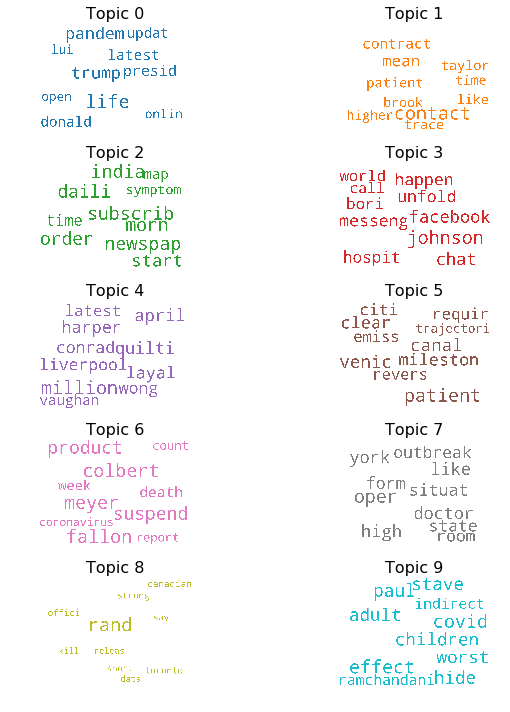

In [46]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [47]:
import pyLDAvis
import pyLDAvis.gensim

In [48]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf,corpus_tfidf,dictionary)

/Users/vignesh/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.098636  0.128784       1        1  14.377710
3     -0.022081 -0.058806       2        1  13.278292
0     -0.034980 -0.070762       3        1  11.680755
9     -0.008363 -0.003139       4        1   9.968909
4     -0.003088 -0.025752       5        1   9.640954
6     -0.016767  0.004431       6        1   9.466496
1      0.001616 -0.014593       7        1   8.250463
5      0.020361 -0.013491       8        1   8.196629
7     -0.001222 -0.003009       9        1   7.931622
8      0.163158  0.056338      10        1   7.208169, topic_info=     Category       Freq      Term      Total  loglift  logprob
106   Default  97.000000      rand  97.000000  30.0000  30.0000
416   Default  11.000000   newspap  11.000000  29.0000  29.0000
418   Default  12.000000  subscrib  12.000000  28.0000  28.0000
415   Default  12.000000      morn  12.000000  27.0000  27.0000
42    Default  13.000000     india  13.000000  26.0000  26.0000
417   Default  12.000000     order  12.000000  25.0000  25.0000
155   Default  12.000000     start  12.000000  24.0000  24.0000
414   Default  15.000000     daili  15.000000  23.0000  23.0000
523   Default   8.000000      life   8.000000  22.0000  22.0000
885   Default   7.000000       map   7.000000  21.0000  21.0000
2250  Default   4.000000     meyer   4.000000  20.0000  20.0000
2248  Default   4.000000   colbert   4.000000  19.0000  19.0000
2249  Default   4.000000    fallon   4.000000  18.0000  18.0000
915   Default   5.000000   product   5.000000  17.0000  17.0000
1308  Default   5.000000   suspend   5.000000  16.0000  16.0000
87    Default  11.000000     trump  11.000000  15.0000  15.0000
269   Default   7.000000    latest   7.000000  14.0000  14.0000
1540  Default   6.000000   johnson   6.000000  13.0000  13.0000
378   Default   8.000000   symptom   8.000000  12.0000  12.0000
532   Default   4.000000      chat   4.000000  11.0000  11.0000
189   Default   5.000000  facebook   5.000000  10.0000  10.0000
82    Default   9.000000    presid   9.000000   9.0000   9.0000
535   Default   4.000000    unfold   4.000000   8.0000   8.0000
534   Default   4.000000   messeng   4.000000   7.0000   7.0000
1384  Default   4.000000   contact   4.000000   6.0000   6.0000
30    Default   7.000000   patient   7.000000   5.0000   5.0000
74    Default   7.000000    donald   7.000000   4.0000   4.0000
12    Default   4.000000      josi   4.000000   3.0000   3.0000
8     Default   4.000000      ford   4.000000   2.0000   2.0000
533   Default   4.000000    happen   4.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
3196  Topic10   0.341786     huddl   0.890892   1.6719  -6.9878
3198  Topic10   0.341786  reckless   0.890892   1.6719  -6.9878
3199  Topic10   0.341786  unreport   0.890892   1.6719  -6.9878
3197  Topic10   0.341786  offshoot   0.890892   1.6719  -6.9878
1978  Topic10   0.882646      kill   2.307216   1.6691  -6.0391
2493  Topic10   0.333867     prais   0.882977   1.6574  -7.0113
3033  Topic10   0.332722   horribl   0.881828   1.6553  -7.0147
1187  Topic10   0.475464   express   1.295095   1.6279  -6.6577
245   Topic10   0.868754     model   2.571774   1.5447  -6.0550
1465  Topic10   0.474371     squar   1.311523   1.6130  -6.6600
971   Topic10   0.871281    releas   3.633727   1.2019  -6.0521
569   Topic10   0.793513   contain   3.163244   1.2471  -6.1456
229   Topic10   0.917950      data   4.445693   1.0524  -5.9999
656   Topic10   0.433026      loan   1.315300   1.5189  -6.7512
690   Topic10   0.818047     place   4.116564   1.0141  -6.1151
474   Topic10   0.965745    offici   7.385569   0.5956  -5.9491
1649  Topic10   0.463611      debt   1.532341   1.4344  -6.6830
652   Topic10   0.607579   billion   2.759168   1.1168  -6.4125
853   Topic10   0.508774     initi   1.928014   1.2977  -6.5900
246   Topic10   0.822349    nation   7.309052

In [73]:
for i in range(10):
    print(i,topics[i][1][0][0],"\n")


0 life 

1 contact 

2 newspap 

3 johnson 

4 million 

5 patient 

6 meyer 

7 oper 

8 rand 

9 covid 



In [74]:
for i in range(10):
    print(i,topics[i][1][0][0],",",topics[i][1][1][0],"\n")



0 life , trump 

1 contact , mean 

2 newspap , india 

3 johnson , facebook 

4 million , april 

5 patient , venic 

6 meyer , colbert 

7 oper , high 

8 rand , canadian 

9 covid , effect 



In [67]:
from autocorrect import Speller

In [68]:
check = Speller(lang='en')

In [69]:
for i in range(10):
    print(i,check(topics[i][1][0][0]),",",check(topics[i][1][1][0]),"\n")

0 life , trump 

1 contact , mean 

2 newspaper , india 

3 johnson , talebook 

4 million , april 

5 patient , venice 

6 mewer , colbert 

7 over , high 

8 rand , canadian 

9 covid , effect 



In [4]:
news_content_uniq.to_csv('news_cont.csv',index=False)